In [1]:
# Imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import joblib
import sklearn
print("sklearn version:", sklearn.__version__)

sklearn version: 1.5.1


In [3]:
# load dataset
csv_path = "C:\\Users\\rahim\\Downloads\\Telco-Customer-Churn.csv"
df = pd.read_csv(csv_path)
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
# Quick cleaning & convert TotalCharges
df = df.copy()
# Replace blanks used as missing and coerce TotalCharges to numeric
df.replace(" ", np.nan, inplace=True)
if 'TotalCharges' in df.columns:
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

print("Missing values:\n", df.isna().sum())
# drop rows with missing values
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)
print("After dropna, shape:", df.shape)

Missing values:
 customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64
After dropna, shape: (7032, 21)


In [7]:
# Drop identifier (customerID) and prepare features/target
if 'customerID' in df.columns:
    df = df.drop(columns=['customerID'])
else:
    print("customerID not found - ok")

# Map target to 0/1
y = df['Churn'].map({'No': 0, 'Yes': 1})
X = df.drop(columns=['Churn'])

print("X shape:", X.shape, "y distribution:\n", y.value_counts(normalize=True))

X shape: (7032, 19) y distribution:
 Churn
0    0.734215
1    0.265785
Name: proportion, dtype: float64


In [9]:
# Column lists
cat_cols = X.select_dtypes(include=['object']).columns.tolist()
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
print("Categorical columns:", cat_cols)
print("Numerical columns:", num_cols)

Categorical columns: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
Numerical columns: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']


In [11]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

Train shape: (5625, 19) Test shape: (1407, 19)


In [13]:
# Build OneHotEncoder with version-aware parameter
from packaging import version
skver = version.parse(sklearn.__version__)

if skver >= version.parse("1.2"):
    # sklearn >= 1.2 uses sparse_output
    ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
else:
    # older sklearn uses sparse
    ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)

preprocessor = ColumnTransformer([
    ('onehot', ohe, cat_cols),
    ('scale', StandardScaler(), num_cols)
], remainder='drop')

In [15]:
# Logistic Regression pipeline
log_reg_model = Pipeline([
    ('preprocess', preprocessor),
    ('clf', LogisticRegression(max_iter=1000, random_state=42))
])

log_reg_model.fit(X_train, y_train)

y_pred_lr = log_reg_model.predict(X_test)
y_proba_lr = log_reg_model.predict_proba(X_test)[:,1] if hasattr(log_reg_model.named_steps['clf'], "predict_proba") else None

print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))
if y_proba_lr is not None:
    print("Logistic ROC AUC:", roc_auc_score(y_test, y_proba_lr))

Logistic Regression Accuracy: 0.8052594171997157
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1033
           1       0.65      0.57      0.61       374

    accuracy                           0.81      1407
   macro avg       0.75      0.73      0.74      1407
weighted avg       0.80      0.81      0.80      1407

Logistic ROC AUC: 0.8360739966143986


In [17]:
# Random Forest pipeline
rf_model = Pipeline([
    ('preprocess', preprocessor),
    ('clf', RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1))
])

rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)
y_proba_rf = rf_model.predict_proba(X_test)[:,1]

print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))
print("Random Forest ROC AUC:", roc_auc_score(y_test, y_proba_rf))

Random Forest Accuracy: 0.7867803837953091
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1033
           1       0.62      0.50      0.55       374

    accuracy                           0.79      1407
   macro avg       0.73      0.69      0.71      1407
weighted avg       0.78      0.79      0.78      1407

Random Forest ROC AUC: 0.818319002334719


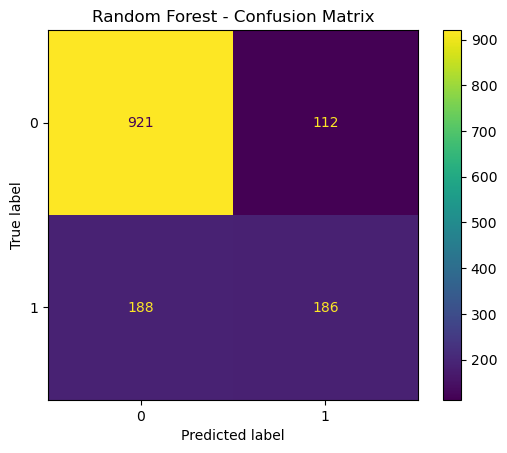

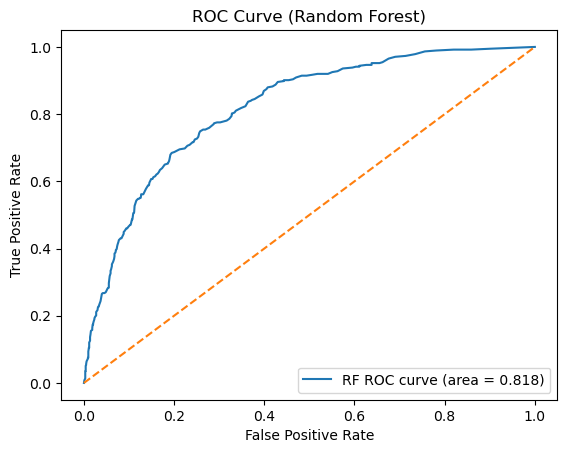

In [19]:
# Confusion matrix and ROC curve (for RF)
from sklearn.metrics import ConfusionMatrixDisplay, roc_curve, auc

# Confusion matrix
ConfusionMatrixDisplay.from_estimator(rf_model, X_test, y_test)
plt.title("Random Forest - Confusion Matrix")
plt.show()

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_proba_rf)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f'RF ROC curve (area = {roc_auc:.3f})')
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Random Forest)')
plt.legend(loc='lower right')
plt.show()

Top 20 feature importances:
scale__TotalCharges                              0.196936
scale__tenure                                    0.167306
scale__MonthlyCharges                            0.166867
onehot__InternetService_Fiber optic              0.038571
onehot__PaymentMethod_Electronic check           0.036138
onehot__Contract_Two year                        0.033587
onehot__gender_Male                              0.028064
onehot__PaperlessBilling_Yes                     0.025881
onehot__OnlineSecurity_Yes                       0.025683
onehot__Contract_One year                        0.024366
onehot__TechSupport_Yes                          0.024130
onehot__Partner_Yes                              0.023157
onehot__OnlineBackup_Yes                         0.022553
scale__SeniorCitizen                             0.020836
onehot__Dependents_Yes                           0.020644
onehot__MultipleLines_Yes                        0.020223
onehot__DeviceProtection_Yes                

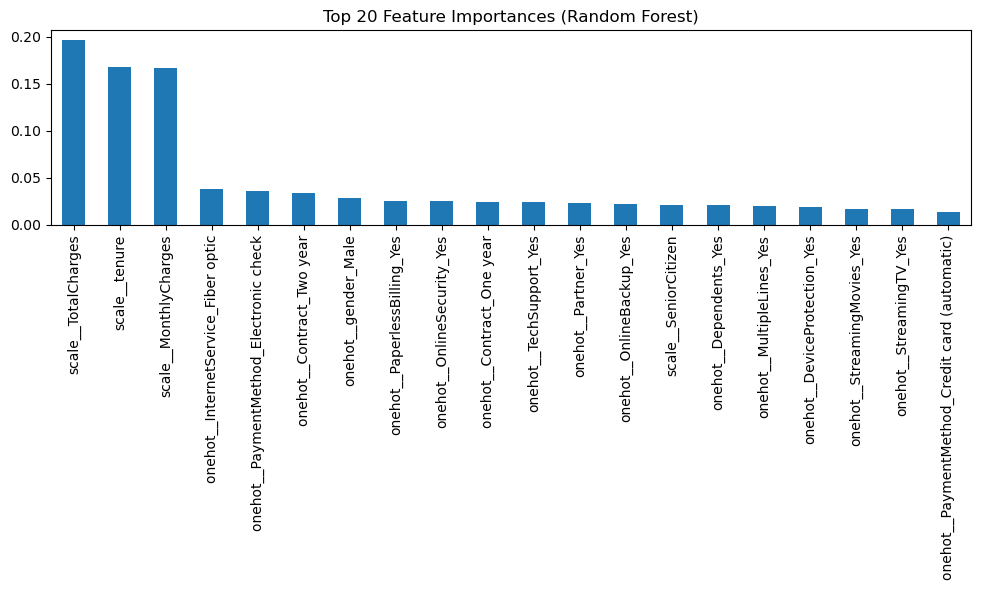

In [21]:
# Feature importances from Random Forest mapped to transformed feature names
# attempt to get feature names from preprocessor
try:
    # scikit-learn >=1.0 has get_feature_names_out
    feature_names = preprocessor.get_feature_names_out()
except Exception:
    # fallback: build names manually using categories_ from fitted onehot
    onehot = preprocessor.named_transformers_['onehot']
    cat_feature_names = []
    if hasattr(onehot, "categories_"):
        for col, cats in zip(cat_cols, onehot.categories_):
            # drop first because drop='first'
            cat_feature_names += [f"{col}_{c}" for c in cats[1:]]
    feature_names = np.array(cat_feature_names + num_cols)

rf_clf = rf_model.named_steps['clf']
importances = rf_clf.feature_importances_
fi = pd.Series(importances, index=feature_names).sort_values(ascending=False)
print("Top 20 feature importances:")
print(fi.head(20))

plt.figure(figsize=(10,6))
fi.head(20).plot(kind='bar')
plt.title("Top 20 Feature Importances (Random Forest)")
plt.tight_layout()
plt.show()

In [23]:
# Save the RF pipeline (includes preprocessing)
os.makedirs('models', exist_ok=True)
model_path = 'models/churn_rf_pipeline.pkl'
joblib.dump(rf_model, model_path)
print("Saved RF pipeline to", model_path)

# Save the logistic model
joblib.dump(log_reg_model, 'models/churn_logreg_pipeline.pkl')
print("Saved Logistic pipeline to models/churn_logreg_pipeline.pkl")

Saved RF pipeline to models/churn_rf_pipeline.pkl
Saved Logistic pipeline to models/churn_logreg_pipeline.pkl
